<a href="https://colab.research.google.com/github/weihaotey/dl-imperial-maths/blob/master/final_assignment_weihao_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Generative Adversarial Network

In this assignment, the goal is to generate random but distinctive and clear images mimicking from the fashion MNIST. There are many generative models that have been researched on in recent years, but here we will focus on the application of **Generative Adversarial Network (GAN)**.

The idea of GAN is to design two convolution networks:

1. _Discriminator :_  
Differentiate inputs from the real source (fashion MNIST) and from fake generated images from the _generator_ function.

2. _Generator :_   
Generate fake images (from normal distribution) that aimed to mimic images from the source.

Hence, the discriminator is trained to recognize real image from the fake ones while the generator is trained to produce images that are closer each step to the original source until they are indistinguishable. 

_Tensorflow_ is used to utilise the useful function defined in the package for the convolutional neuron network in discriminator and generator functions.

Firstly, we need to include some necessary packages like tensorflow and numpy for the neuron network. Next, extract data from the idx files from fashion MNIST as numpy arrays. Note that only the actual training data (training and test set are concatenated and treat as the training data) are needed for GAN. Their labels are included for completeness.


In [0]:
import tensorflow as tf
import numpy as np

def load_mnist(path, kind='train'):
    import os
    import gzip

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 28, 28)

    return images, labels
  

train_X, train_Y = load_mnist('', kind='train')
test_X, test_Y = load_mnist('', kind='t10k')

In [0]:
#X = np.concatenate((train_set, test_set), axis=0) #mix both train set and test set
#y = np.concatenate((train_label, test_label), axis=0).astype(np.int) #the label would not be used in this GAN model
#print(X.shape)
#print(y.shape)
      
#randomize the data
#seed = 952
#np.random.seed(seed)
#np.random.shuffle(train_set)
#np.random.seed(seed)
#np.random.shuffle(Train_label)


train_set = np.expand_dims(train_X, axis=3)
train_label = np.expand_dims(train_Y, axis=1)
test_set = np.expand_dims(test_X, axis=3)
test_label = np.expand_dims(test_Y, axis=1)
#transform to vectors with the label position as the digit 1 (one-hot vector)
train_labels = np.zeros((len(train_label), 10), dtype=np.float)
for i, label in enumerate(train_label):
    train_labels[i, train_label[i]] = 1.0

#normalize the tensor X 
#train_set = np.reshape(len(train_set),28,28)
data_fashion = [train_set / 255., train_label]
print('shape of: train_set {}, train_label{},\n test_set{}, test_label{}'.format(train_set.shape,train_label.shape,test_set.shape,test_label.shape))

shape of: train_set (60000, 28, 28, 1), train_label(60000, 1),
 test_set(10000, 28, 28, 1), test_label(10000, 1)


###Some handling functions

Some side functions that do not directly involved on the training like handling and saving images are pre-defined to simplify the training code.



In [0]:
import scipy.misc
import os
import tensorflow.contrib.slim as slim #for printing variables

#check if folder exists before writing into the file
def check_folder(log_dir):
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    return log_dir

def display_vars():
    model_vars = tf.trainable_variables()
    slim.model_analyzer.analyze_vars(model_vars, print_info=True)

#for saving image every 300 steps
def save_images(images, size, image_path):
    return imsave(inverse_transform(images), size, image_path)

def imread(path, grayscale = False):
    if (grayscale):
        return scipy.misc.imread(path, flatten = True).astype(np.float)
    else:
        return scipy.misc.imread(path).astype(np.float)
      
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    if (images.shape[3] in (3,4)):
        c = images.shape[3]
        img = np.zeros((h * size[0], w * size[1], c))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w, :] = image
        return img
    elif images.shape[3]==1:
        img = np.zeros((h * size[0], w * size[1]))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w] = image[:,:,0]
        return img
    else:
        raise ValueError('in merge(images,size) images parameter ''must have dimensions: HxW or HxWx3 or HxWx4')

def imsave(images, size, path):
    image = np.squeeze(merge(images, size))
    return scipy.misc.imsave(path, image)

def center_crop(x, crop_h, crop_w, resize_h=64, resize_w=64):
    if crop_w is None:
        crop_w = crop_h
    h, w = x.shape[:2]
    j = int(round((h - crop_h)/2.))
    i = int(round((w - crop_w)/2.))
    return scipy.misc.imresize(x[j:j+crop_h, i:i+crop_w], [resize_h, resize_w])

def transform(image, input_height, input_width, resize_height=64, resize_width=64, crop=True):
    if crop:
        cropped_image = center_crop(image, input_height, input_width, resize_height, resize_width)
    else:
        cropped_image = scipy.misc.imresize(image, [resize_height, resize_width])
    return np.array(cropped_image)/127.5 - 1.

def inverse_transform(images):
    return (images+1.)/2.

###Main Functions 

Now, we define some important functions that set the core of the convolutional network in _discriminator_ and _generator_. The activation function used here is leaky ReLU as suggested in []. 

In [0]:
#batch norm function
def bn(x, is_training, name):
    return tf.layers.batch_normalization(x, training=is_training, name=name)
    #return tf.contrib.layers.batch_norm(x,decay=0.9,updates_collections=None,epsilon=1e-5,scale=True,is_training=is_training,scope=scope)

#convolution 
def conv2d(input_, output_dim, k_h=5, k_w=5, d_h=2, d_w=2, name="conv2d"):
    with tf.variable_scope(name):
        conv = tf.layers.conv2d(input_, output_dim, (k_h, k_w), strides=(d_h, d_w), padding='same', 
                             data_format='channels_last', activation=None, use_bias=True,
                             kernel_initializer=tf.glorot_normal_initializer(), name=name)

        return conv

#deconvolution
def deconv2d(input_, output_dim, k_h=5, k_w=5, d_h=2, d_w=2, name="deconv2d"):
    with tf.variable_scope(name):
        deconv = tf.layers.conv2d_transpose(input_, output_dim, (k_h, k_w), strides=(d_h, d_w), padding='same', 
                             data_format='channels_last', activation=None, use_bias=True,
                             kernel_initializer=tf.glorot_normal_initializer(), name=name)


        return deconv

#Leak ReLU
def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)

#perform activation(inputs * kernel + bias), where activation is leakyReLU 
def dense(input_, output_size, name = None):
        
    return tf.layers.dense(input_, output_size, kernel_initializer=tf.glorot_normal_initializer(), 
                            activation=tf.nn.leaky_relu, name=name)

###Main training functions using _GAN_

Define a _GAN_ class and create the functions _discriminator_ and _generator_ with convolutional and deconvolutional layer with some specific strides and same padding are used. 

####Hyper-parameters

Adam Optimizer  
 - Learning rate : 0.0002
 - Beta : 0.5
 
Height and width dimension of MNIST image : 28
 
Number of generated image to be saved : 64
 
Batch size : 64

Total number of training epoch : 30

dimension of noise vector : 62


In [0]:
import time #to display and record time

class GAN(object):
    model_name = "GAN"     # name for checkpoint

    def __init__(self, sess, epoch, batch_size, z_dim, data_fashion, checkpoint_dir, result_dir, log_dir):
        self.sess = sess
        self.data_fashion = data_fashion
        self.checkpoint_dir = checkpoint_dir
        self.result_dir = result_dir
        self.log_dir = log_dir
        self.epoch = epoch
        self.batch_size = batch_size
        
        self.input_height = 28
        self.input_width = 28
        self.output_height = 28
        self.output_width = 28

        self.z_dim = z_dim         # dimension of noise-vector
        self.c_dim = 1

        # train parameter
        self.learning_rate = 0.0002
        self.beta1 = 0.5

        # number of generated images to be saved
        self.sample_num = 64  

        # load data
        self.data_X = data_fashion[0]
        self.data_y = data_fashion[1]

        # get number of batches for a single epoch
        self.num_batches = len(self.data_X) // self.batch_size
        
        
    def discriminator(self, x, is_training=True, reuse=False):
        # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
        # Architecture : (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S
        with tf.variable_scope("discriminator", reuse=reuse):

            h = lrelu(conv2d(x, 64, 4, 4, 2, 2, name='d_conv1'))
            h = lrelu(bn(conv2d(h, 128, 4, 4, 2, 2, name='d_conv2'), is_training=is_training, name='d_bn2'))
            h = tf.reshape(h, [self.batch_size, -1])
            h = lrelu(bn(dense(h, 1024, name='d_fc3'), is_training=is_training, name='d_bn3'))
            out_logit = dense(h, 1, name='d_fc4')
            out = tf.nn.sigmoid(out_logit)

            return out, out_logit, h

    def generator(self, z, is_training=True, reuse=False):
        # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
        # Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
        with tf.variable_scope("generator", reuse=reuse):
            h = lrelu(bn(dense(z, 1024, name='g_fc1'), is_training=is_training, name='g_bn1'))
            h = lrelu(bn(dense(h, 128 * 7 * 7, name='g_fc2'), is_training=is_training, name='g_bn2'))
            h = tf.reshape(h, [self.batch_size, 7, 7, 128])
            h = lrelu(
                bn(deconv2d(h, 64, 4, 4, 2, 2, name='g_dc3'), is_training=is_training,
                   name='g_bn3'))

            out = tf.nn.sigmoid(deconv2d(h, 1, 4, 4, 2, 2, name='g_dc4'))

            return out

    def build_model(self):
        # some parameters
        image_dims = [self.input_height, self.input_width, self.c_dim]
        bs = self.batch_size

        """ Graph Input """
        # images
        self.inputs = tf.placeholder(tf.float32, [bs] + image_dims, name='real_images')

        # noises
        self.z = tf.placeholder(tf.float32, [bs, self.z_dim], name='z')

        """ Loss Function """

        # output of D for real images
        D_real, D_real_logits, _ = self.discriminator(self.inputs, is_training=True, reuse=False)

        # output of D for fake images
        G = self.generator(self.z, is_training=True, reuse=False)
        D_fake, D_fake_logits, _ = self.discriminator(G, is_training=True, reuse=True)

        # get loss for discriminator
        d_loss_real = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones_like(D_real)))
        d_loss_fake = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros_like(D_fake)))

        self.d_loss = d_loss_real + d_loss_fake
        self.d_loss_real = d_loss_real
        self.d_loss_fake = d_loss_fake

        # get loss for generator
        self.g_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones_like(D_fake)))

        """ Training """
        # divide trainable variables into a group for D and a group for G
        t_vars = tf.trainable_variables()
        d_vars = [var for var in t_vars if 'd_' in var.name]
        g_vars = [var for var in t_vars if 'g_' in var.name]

        # optimizers
        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
            self.d_optim = tf.train.AdamOptimizer(self.learning_rate, beta1=self.beta1) \
                      .minimize(self.d_loss, var_list=d_vars)
            self.g_optim = tf.train.AdamOptimizer(self.learning_rate*5, beta1=self.beta1) \
                      .minimize(self.g_loss, var_list=g_vars)

        """" Testing """
        # for test
        self.fake_images = self.generator(self.z, is_training=False, reuse=True)

        """ Summary """
        d_loss_real_sum = tf.summary.scalar("d_loss_real", d_loss_real)
        d_loss_fake_sum = tf.summary.scalar("d_loss_fake", d_loss_fake)
        d_loss_sum = tf.summary.scalar("d_loss", self.d_loss)
        g_loss_sum = tf.summary.scalar("g_loss", self.g_loss)

        # final summary operations
        self.g_sum = tf.summary.merge([d_loss_fake_sum, g_loss_sum])
        self.d_sum = tf.summary.merge([d_loss_real_sum, d_loss_sum])

    def train(self):

        # initialize all variables
        tf.global_variables_initializer().run()

        # graph inputs for visualize training results
        self.sample_z = np.random.uniform(-1, 1, size=(self.batch_size , self.z_dim))

        # saver to save model
        self.saver = tf.train.Saver()

        # summary writer
        self.writer = tf.summary.FileWriter(self.log_dir + '/' + self.model_name, self.sess.graph)

        # restore check-point if it exits
        could_load, checkpoint_counter = self.load(self.checkpoint_dir)
        if could_load:
            start_epoch = (int)(checkpoint_counter / self.num_batches)
            start_batch_id = checkpoint_counter - start_epoch * self.num_batches
            counter = checkpoint_counter
            print(" [*] Load SUCCESS")
        else:
            start_epoch = 0
            start_batch_id = 0
            counter = 1
            print(" [!] Load failed...")

        # loop for epoch
        start_time = time.time()
        dataplot = [] #for the plot of losses
        for epoch in range(start_epoch, self.epoch):

            # get batch data
            for idx in range(start_batch_id, self.num_batches):
                #data for real images
                batch_images = self.data_X[idx*self.batch_size:(idx+1)*self.batch_size]
                           
                #data for fake images from uniform distribution
                batch_z = np.random.uniform(-1, 1, [self.batch_size, self.z_dim]).astype(np.float32)

                # update D network
                _, summary_str, d_loss, d_loss_real, d_loss_fake = self.sess.run([self.d_optim, self.d_sum, self.d_loss, self.d_loss_real, self.d_loss_fake],
                                               feed_dict={self.inputs: batch_images, self.z: batch_z})
                self.writer.add_summary(summary_str, counter)

                # update G network
                _, summary_str, g_loss = self.sess.run([self.g_optim, self.g_sum, self.g_loss], feed_dict={self.inputs: batch_images, self.z: batch_z})
                self.writer.add_summary(summary_str, counter)
                

                # display training status
                if np.mod(counter, 30) == 0:                 
                  	print("Epoch: [%2d] [%4d/%4d] time: %4.4f, d_loss: %.8f, g_loss: %.8f" \
                        % (epoch, idx, self.num_batches, time.time() - start_time, d_loss, g_loss))
                
                # track d_loss and g_loss for plot
                if np.mod(counter, 30) == 0:
                    dataplot.append([counter, d_loss_real, d_loss_fake, d_loss, g_loss])

                # save training results for every 300 steps
                if np.mod(counter, 300) == 0:
                    samples = self.sess.run(self.fake_images, feed_dict={self.z: self.sample_z})
                    tot_num_samples = min(self.sample_num, self.batch_size)
                    manifold_h = int(np.floor(np.sqrt(tot_num_samples)))
                    manifold_w = int(np.floor(np.sqrt(tot_num_samples)))
                    save_images(samples[:manifold_h * manifold_w, :, :, :], [manifold_h, manifold_w],
                                './' + check_folder(self.result_dir + '/' + self.model_dir) + '/' + self.model_name + '_train_{:02d}_{:04d}.png'.format(
                                    epoch, idx))
                counter += 1

            # After an epoch, start_batch_id is set to zero
            # non-zero value is only for the first epoch after loading pre-trained model
            start_batch_id = 0

            # save model
            self.save(self.checkpoint_dir, counter)

            # show temporal results
            self.visualize_results(epoch)

        # save model for final step
        self.save(self.checkpoint_dir, counter)
        dataplot = np.array(dataplot)
        return dataplot

    def visualize_results(self, epoch):
        tot_num_samples = min(self.sample_num, self.batch_size)
        image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))

        """ random condition, random noise """

        z_sample = np.random.uniform(-1, 1, size=(self.batch_size, self.z_dim))

        samples = self.sess.run(self.fake_images, feed_dict={self.z: z_sample})

        save_images(samples[:image_frame_dim * image_frame_dim, :, :, :], [image_frame_dim, image_frame_dim],
                    check_folder(self.result_dir + '/' + self.model_dir) + '/' + self.model_name + '_epoch%03d' % epoch + '_test_all_classes.png')

    @property
    def model_dir(self):
        return "{}_{}_{}_{}".format(
            self.model_name, 'fashion',
            self.batch_size, self.z_dim)

    def save(self, checkpoint_dir, step):
        checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir, self.model_name)

        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        self.saver.save(self.sess,os.path.join(checkpoint_dir, self.model_name+'.model'), global_step=step)

    def load(self, checkpoint_dir):
        import re
        print(" [*] Reading checkpoints...")
        checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir, self.model_name)

        ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
        if ckpt and ckpt.model_checkpoint_path:
            ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
            self.saver.restore(self.sess, os.path.join(checkpoint_dir, ckpt_name))
            counter = int(next(re.finditer("(\d+)(?!.*\d)",ckpt_name)).group(0))
            print(" [*] Success to read {}".format(ckpt_name))
            return True, counter
        else:
            print(" [*] Failed to find a checkpoint")
            return False, 0

In [0]:
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:

    epoch = 30
    batch_size = 64
    z_dim = 62
    checkpoint_dir = 'checkpoint'
    result_dir = 'result'
    log_dir = 'logs'
  

    gan = GAN(sess,
                            epoch=epoch,
                            batch_size=batch_size,
                            z_dim=z_dim,
                            data_fashion=data_fashion,
                            checkpoint_dir=checkpoint_dir,
                            result_dir=result_dir,
                            log_dir=log_dir)

    # build graph
    gan.build_model()

    # show network architecture
    display_vars()

    # launch the graph in a session
    dataplot = gan.train()
    print(" [*] Training finished!")

    # visualize learned generator
    gan.visualize_results(epoch-1)
    print(" [*] Testing finished!")

---------
Variables: name (type shape) [size]
---------
discriminator/d_conv1/d_conv1/kernel:0 (float32_ref 4x4x1x64) [1024, bytes: 4096]
discriminator/d_conv1/d_conv1/bias:0 (float32_ref 64) [64, bytes: 256]
discriminator/d_conv2/d_conv2/kernel:0 (float32_ref 4x4x64x128) [131072, bytes: 524288]
discriminator/d_conv2/d_conv2/bias:0 (float32_ref 128) [128, bytes: 512]
discriminator/d_bn2/gamma:0 (float32_ref 128) [128, bytes: 512]
discriminator/d_bn2/beta:0 (float32_ref 128) [128, bytes: 512]
discriminator/d_fc3/kernel:0 (float32_ref 6272x1024) [6422528, bytes: 25690112]
discriminator/d_fc3/bias:0 (float32_ref 1024) [1024, bytes: 4096]
discriminator/d_bn3/gamma:0 (float32_ref 1024) [1024, bytes: 4096]
discriminator/d_bn3/beta:0 (float32_ref 1024) [1024, bytes: 4096]
discriminator/d_fc4/kernel:0 (float32_ref 1024x1) [1024, bytes: 4096]
discriminator/d_fc4/bias:0 (float32_ref 1) [1, bytes: 4]
generator/g_fc1/kernel:0 (float32_ref 62x1024) [63488, bytes: 253952]
generator/g_fc1/bias:0 (flo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Epoch: [ 0] [ 329/ 937] time: 16.6387, d_loss: 1.31401467, g_loss: 0.79062843
Epoch: [ 0] [ 359/ 937] time: 17.7638, d_loss: 1.22324586, g_loss: 0.80476201
Epoch: [ 0] [ 389/ 937] time: 18.8960, d_loss: 1.26483011, g_loss: 0.78119206
Epoch: [ 0] [ 419/ 937] time: 20.0218, d_loss: 1.27990961, g_loss: 0.79589874
Epoch: [ 0] [ 449/ 937] time: 21.1500, d_loss: 1.24409270, g_loss: 0.76937401
Epoch: [ 0] [ 479/ 937] time: 22.2805, d_loss: 1.27893519, g_loss: 0.80701923
Epoch: [ 0] [ 509/ 937] time: 23.3992, d_loss: 1.32561016, g_loss: 0.81213969
Epoch: [ 0] [ 539/ 937] time: 24.5251, d_loss: 1.28423202, g_loss: 0.79710889
Epoch: [ 0] [ 569/ 937] time: 25.6575, d_loss: 1.28395069, g_loss: 0.78495568
Epoch: [ 0] [ 599/ 937] time: 26.7857, d_loss: 1.29211307, g_loss: 0.82007259
Epoch: [ 0] [ 629/ 937] time: 27.9270, d_loss: 1.35966420, g_loss: 0.78287303
Epoch: [ 0] [ 659/ 937] time: 29.0594, d_loss: 1.27399886, g_loss: 0.78450567
Epoch: [ 0] [ 689/ 937] time: 30.1907, d_loss: 1.39026666, g_los

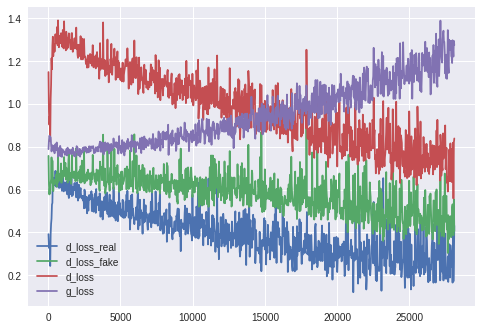

In [0]:
from matplotlib import pyplot as plt
iteration = dataplot[:,0]
d_loss_real = dataplot[:,1]
d_loss_fake = dataplot[:,2]
d_loss = dataplot[:,3]
g_loss = dataplot[:,4]

d_real, = plt.plot(iteration, d_loss_real, label='d_loss_real')
d_fake, = plt.plot(iteration, d_loss_fake, label='d_loss_fake')
d, = plt.plot(iteration, d_loss, label='d_loss')
g, = plt.plot(iteration, g_loss, label='g_loss')

plt.legend(handles=[d_real, d_fake, d, g])
plt.savefig('loss(uniform).png',format='png')
plt.show()




###Difference between using uniform or normal initializer

According to the original source of the code for *GAN*, the initializer from uniform distribution is used and the training curve in terms of the loss function for both _generator_ and _discriminator_ is shown in Figure 1. 

However, as stated in the lectures of this course, researher found that using sample from a gaussian distribution (normal) would improve the result. This is proved by the graph of training curve using _normal_ initializer as shown in Figure 2. It can be seen that in Figure 2, the loss of generator increase slower than that of Figure 1 where _uniform_ distribution is used. The fluctuation of the losses are also generally lower using normal initializer. However, The generator loss still exceed the loss of discriminator eventually in both figures.

![Figure 1: Losses from uniform initializer](loss(uniform).png)

![Figure 2: Losses from normal initializer](loss(normal) (1).png)

![GAN](loss (3).png)



Figure 1 : Losses from uniform initializer


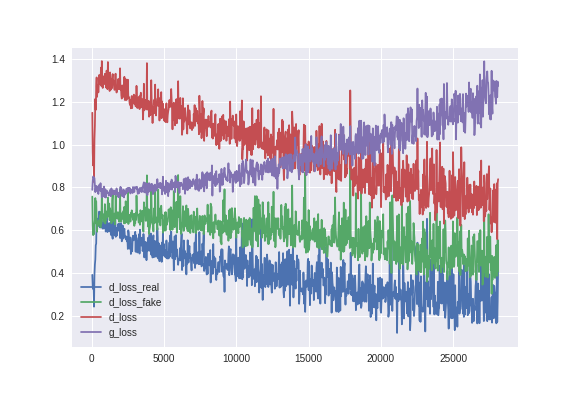

Figure 2 : Losses from normal initializer


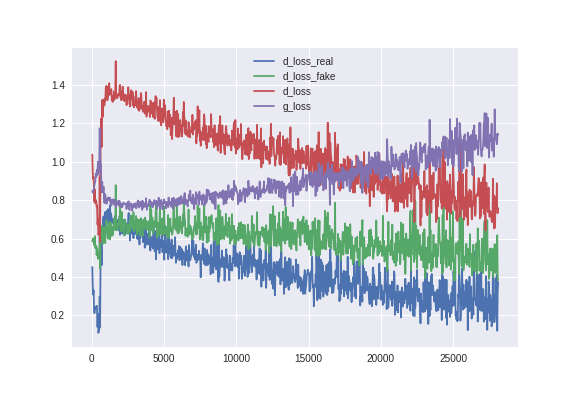

Figure 3 : losses curve produced using normal initializer and original architexture using tf.conv.layer.


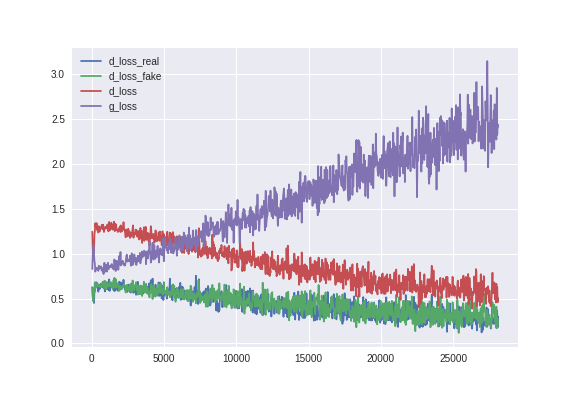

In [0]:
from IPython.display import Image
print('Figure 1 : Losses from uniform initializer')
display(Image('loss(uniform).png'))
print('Figure 2 : Losses from normal initializer')
display(Image('loss(normal) (1).png'))
print('Figure 3 : losses curve produced using normal initializer and original architexture using tf.conv.layer.')
display(Image('loss (3).png'))


In [0]:
#produce real image to compare with generated
samples = train_set[0:64]
image_frame_dim = 8
save_images(samples[:image_frame_dim * image_frame_dim, :, :, :], [image_frame_dim, image_frame_dim],
        'GAN' + 'real_image.png')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
